```{include} ../math-definitions.md
```

In [1]:
import bccr
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


isi = bccr.SW({'25725':'isi'})
res = ARIMA(isi, order=[3,0,0]).fit()

# Pronósticos con modelos ARMA

## Pronósticos con modelos ARMA

Sea $y^*_{t+j|t}$ un pronóstico de $y_{t+j}$ pasado en datos observados hasta $t$.

Definimos el “mejor” pronóstico de este tipo como aquel que minimiza el **error cuadrático medio**
\begin{equation*}
\text{MSE}\left(y^*_{t+j|t}\right) \equiv \E\left(y_{t+j} - y^*_{t+j|t}\right)^2
\end{equation*}

Aunque no lo probamos aquí, resulta que el pronóstico con el menor error cuadrático medio es la esperanza de $y_{t+j}$ condicional en los datos hasta $t$:
\begin{equation*}
y^*_{t+j|t} = \E\left(y_{t+j} | y_t, y_{t-1}, \dots \right) \equiv \E_t\left(y_{t+j}\right)
\end{equation*}



## Pronosticando valores puntuales de la serie

Es muy sencillo obtener de manera recursiva  estos pronósticos para los modelos ARMA, siguiendo estos 3 pasos:

1. Se escribe la ecuación ARMA de manera que $y_t$ quede a la izquierda y todos los otros términos a la derecha.
2. Se sustituye el índice $t$ por $T+h$.
3. En el lado derecho de la ecuación, se sustituyen:
  * observaciones futuras con sus pronósticos,
  * errores futuros con cero,
  * errores pasados con sus respectivos residuos.

Empezando con $h=1$, se repiten los pasos 2 y 3 para valores $h=2,3,\dots$ hasta que todos los pronósticos hayan sido calculados.



Para ilustrar el procedimiento, consideremos este proceso ARMA(1,2)
\begin{equation*}
(1-\phi\Lag)\tilde{y}_t = (1 + \theta_1\Lag + \theta_2\Lag^2)\epsilon_t
\end{equation*}

**Paso 1:** $\tilde{y}_t = \phi\tilde{y}_{t-1} + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2}$

Para $h=1$:
\begin{align*}
\tilde{y}_{T+1} &= \phi\tilde{y}_{T} + \epsilon_{T+1} + \theta_1\epsilon_{T} + \theta_2\epsilon_{T-1}\\
\tilde{y}^*_{T+1|T} &= \phi\tilde{y}_{T} + \theta_1\hat{\epsilon}_{T} + \theta_2\hat{\epsilon}_{T-1}
\end{align*}

Para $h=2$:
\begin{align*}
\tilde{y}_{T+2} &= \phi\tilde{y}_{T+1} + \epsilon_{T+2} + \theta_1\epsilon_{T+1} + \theta_2\epsilon_{T}\\
y^*_{T+2|T} &= \phi\tilde{y}^*_{T+1|T} + \theta_2\hat{\epsilon}_{T}
\end{align*}

Para $h=3$:
\begin{align*}
\tilde{y}_{T+3} &= \phi\tilde{y}_{T+2} + \epsilon_{T+3} + \theta_1\epsilon_{T+2} + \theta_2\epsilon_{T+1}\\
y^*_{T+3|T} &= \phi\tilde{y}^*_{T+2|T}
\end{align*}


Es fácil comprobar que, siguiendo este procedimiento, una vez que $h>p$, $h>q$ la ecuación de pronóstico será
\begin{equation*}
\tilde{y}^*_{T+h} = \phi_1\tilde{y}^*_{T+h-1} + \dots + \phi_p\tilde{y}^*_{T+h-p}
\end{equation*}

Esto es una ecuación en diferencia de orden $p$, de la cual sabemos que sus raíces están dentro del círculo unitario. Por ello
\begin{align*}
\lim\limits_{h\to\infty}\tilde{y}^*_{T+h} &= 0 & \text{es decir }\quad \lim\limits_{h\to\infty}y^*_{T+h} &= \mu
\end{align*}

Esto nos dice que, para valores grandes de $h$, el pronóstico es simplemente la media del proceso.



## Cuantificando la incertidumbre de los pronósticos puntuales

Para saber qué tan precisos esperamos que sean estos pronósticos, necesitamos cuantificar su error cuadrático medio
\begin{align*}
\text{MSE}\left(y^*_{t+j|t}\right) &\equiv \E\left(y_{t+j} - y^*_{t+j|t}\right)^2 \\
                                   &= \E\left(y_{t+j} - \E_t\left(y_{t+j}\right)\right)^2 \\
                                   &= \Var_t\left(y_{t+j}\right)
\end{align*}

Es decir, necesitamos cuantificar la varianza de $y_{t+j}$ condicional en los datos disponibles en $t$.

Por razones de tiempo, no vamos a desarrollar estas fórmulas durante este curso.


{{ empieza_ejemplo }} Pronosticando la inflación {{ fin_titulo_ejemplo }}
```{margin} Archivos:
* bccr.ServicioWeb
* ISI-AR3.ipynb
```

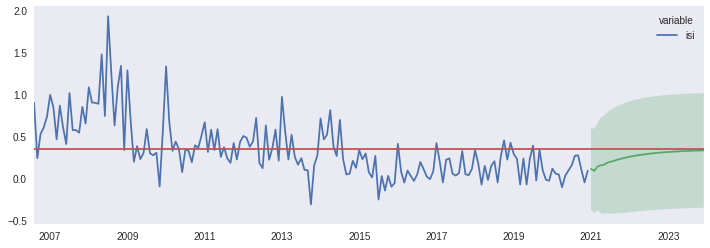

In [2]:
from scipy.stats import norm

plt.style.use('seaborn-dark')
horizon = 36
fcast =res.get_forecast(steps=horizon, alpha=0.05)


fig, ax =plt.subplots(figsize=[12,4])
isi.plot(ax=ax)
fcast.predicted_mean.plot(ax=ax)
ax.axhline(isi.values.mean(), color='C2')


ax.fill_between(fcast.row_labels, *fcast.conf_int().values.T,
                facecolor='C1', alpha=0.25, interpolate=True);

Podemos hacer intervalos de distintos niveles de significancia:

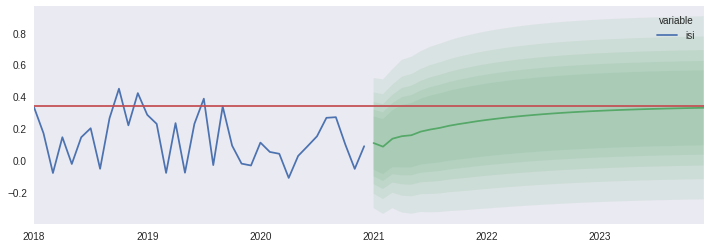

In [3]:
fig, ax =plt.subplots(figsize=[12,4])
isi['2018':].plot(ax=ax)
fcast.predicted_mean.plot(ax=ax)
ax.axhline(isi.values.mean(), color='C2')

for alpha in np.arange(1,6)/10:
    ax.fill_between(fcast.row_labels, *fcast.conf_int(alpha=alpha).values.T,
                facecolor='C1', alpha=0.1, interpolate=True);

## ¿Qué podría salir mal?

En todas las fórmulas que hemos elaborado para los pronósticos hasta ahora, está implícito que conocemos los verdaderos valores de los parámetros.

En la práctica, esos parámetros son estimados a partir de los datos.

Tomemos por ejemplo un proceso AR(1):
\begin{align*}
y_{t+1}     &=  \phi y_t + \epsilon_{t+1} \tag{valor verdadero} \\
y^*_{t+1|t} &= \hat{\phi} y_t  \tag{pronóstico} \\
            &\Rightarrow \\
\notationbrace{y_{t+1} - y^*_{t+1|t}}{error de pronóstico} &= \notationbrace{\left(\phi-\hat{\phi}\right)}{“sesgo”}y_t + \notationbrace{\epsilon_{t+1}}{innovación}
\end{align*}
{{ termina_ejemplo }}